<a href="https://colab.research.google.com/github/Pbrillan/CEIA/blob/main/NLP/Pbrillan_4d_predicci%C3%B3n_palabra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset.csv to dataset.csv
User uploaded file "dataset.csv" with length 39764 bytes


In [3]:
df = pd.read_csv('dataset.csv')
df = df.drop(['humor'],axis=1)
df = df.rename(columns={'text':'0'})
df.head()

,0
0,"Joe biden rules out 2020 bid: 'guys, i'm not r..."
1,Watch: darvish gave hitter whiplash with slow ...
2,What do you call a turtle without its shell? d...
3,5 reasons the 2016 election feels so personal
4,"Pasco police shot mexican migrant from behind,..."


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 542


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [5]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[0,0]
text

"Joe biden rules out 2020 bid: 'guys, i'm not running'"

In [7]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['joe',
 'biden',
 'rules',
 'out',
 '2020',
 'bid',
 "'guys",
 "i'm",
 'not',
 "running'"]

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [8]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [9]:
# Demos un vistazo
sentence_tokens[:2]

[['joe',
  'biden',
  'rules',
  'out',
  '2020',
  'bid',
  "'guys",
  "i'm",
  'not',
  "running'"],
 ['watch', 'darvish', 'gave', 'hitter', 'whiplash', 'with', 'slow', 'pitch']]

In [10]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [11]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['joe', 'biden', 'rules', 'out'],
 ['biden', 'rules', 'out', '2020'],
 ['rules', 'out', '2020', 'bid'],
 ['out', '2020', 'bid', "'guys"],
 ['2020', 'bid', "'guys", "i'm"],
 ['bid', "'guys", "i'm", 'not']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [12]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [13]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[8, 6, 4, 1],
 [6, 4, 1, 2],
 [4, 1, 2, 3],
 [1, 2, 3, 5],
 [2, 3, 5, 7],
 [3, 5, 7, 9]]

In [14]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

6


In [15]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

9


In [16]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'out': 1, '2020': 2, 'bid': 3, 'rules': 4, "'guys": 5, 'biden': 6, "i'm": 7, 'joe': 8, 'not': 9}


In [17]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'joe': 1, 'biden': 2, 'rules': 3, 'out': 4, '2020': 4, 'bid': 4, "'guys": 3, "i'm": 2, 'not': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [18]:
# Vistazo a las primeras filas
df.iloc[:15,0]

0     Joe biden rules out 2020 bid: 'guys, i'm not r...
1     Watch: darvish gave hitter whiplash with slow ...
2     What do you call a turtle without its shell? d...
3         5 reasons the 2016 election feels so personal
4     Pasco police shot mexican migrant from behind,...
5     Martha stewart tweets hideous food photo, twit...
6     What is a pokemon master's favorite kind of pa...
7     Why do native americans hate it when it rains ...
8     Obama's climate change legacy is impressive, i...
9         My family tree is a cactus, we're all pricks.
10    Donald trump has found something mysterious fo...
11    How donald trump and ted cruz's love affair is...
12    Want to know why athletes chose to #takeaknee?...
13    How are music and candy similar? we throw away...
14    Famous couples who help each other stay health...
Name: 0, dtype: object

In [19]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"Joe biden rules out 2020 bid: 'guys, i'm not running' Watch: darvish gave hitter whiplash with slow pitch What do you call a turtle without its shell? dead. 5 reasons the 2016 election feels so personal Pasco police shot mexican migrant from behind, new autopsy shows Martha stewart tweets hideous food photo, twitter responds accordingly What is a pokemon master's favorite kind of pasta? wartortellini! Why do native americans hate it when it rains in april? because it brings mayflowers. Obama's climate change legacy is impressive, imperfect and vulnerable My family tree is a cactus, we're all pricks. Donald trump has found something mysterious for rudy giuliani to do How donald trump and ted cruz's love affair is all relationships Want to know why athletes chose to #takeaknee? look at our broken justice system How are music and candy similar? we throw away the rappers. Famous couples who help each other stay healthy and fit Study finds strong link between zika and guillain-barre syndro

In [20]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['joe',
 'biden',
 'rules',
 'out',
 '2020',
 'bid',
 "'guys",
 "i'm",
 'not',
 "running'",
 'watch',
 'darvish',
 'gave',
 'hitter',
 'whiplash',
 'with',
 'slow',
 'pitch',
 'what',
 'do']

In [21]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 6452


In [22]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [23]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['joe', 'biden', 'rules', 'out'],
 ['biden', 'rules', 'out', '2020'],
 ['rules', 'out', '2020', 'bid'],
 ['out', '2020', 'bid', "'guys"],
 ['2020', 'bid', "'guys", "i'm"],
 ['bid', "'guys", "i'm", 'not'],
 ["'guys", "i'm", 'not', "running'"],
 ["i'm", 'not', "running'", 'watch'],
 ['not', "running'", 'watch', 'darvish'],
 ["running'", 'watch', 'darvish', 'gave'],
 ['watch', 'darvish', 'gave', 'hitter'],
 ['darvish', 'gave', 'hitter', 'whiplash'],
 ['gave', 'hitter', 'whiplash', 'with'],
 ['hitter', 'whiplash', 'with', 'slow'],
 ['whiplash', 'with', 'slow', 'pitch'],
 ['with', 'slow', 'pitch', 'what'],
 ['slow', 'pitch', 'what', 'do'],
 ['pitch', 'what', 'do', 'you'],
 ['what', 'do', 'you', 'call'],
 ['do', 'you', 'call', 'a']]

In [24]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[739, 2599, 738, 53],
 [2599, 738, 53, 387],
 [738, 53, 387, 740],
 [53, 387, 740, 741],
 [387, 740, 741, 45],
 [740, 741, 45, 48],
 [741, 45, 48, 742],
 [45, 48, 742, 119],
 [48, 742, 119, 743],
 [742, 119, 743, 388],
 [119, 743, 388, 744],
 [743, 388, 744, 745],
 [388, 744, 745, 14],
 [744, 745, 14, 389],
 [745, 14, 389, 746],
 [14, 389, 746, 10],
 [389, 746, 10, 11],
 [746, 10, 11, 5],
 [10, 11, 5, 31],
 [11, 5, 31, 2]]

In [25]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 6448


### 3 - Input y target

In [26]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [28]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [29]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(6448, 3)
(6448,)


In [30]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'a',
 3: 'to',
 4: 'of',
 5: 'you',
 6: 'in',
 7: 'and',
 8: 'i',
 9: 'is',
 10: 'what',
 11: 'do',
 12: 'for',
 13: 'my',
 14: 'with',
 15: 'on',
 16: 'why',
 17: 'it',
 18: 'how',
 19: 'are',
 20: 'did',
 21: 'at',
 22: 'have',
 23: 'because',
 24: 'your',
 25: 'he',
 26: 'they',
 27: 'was',
 28: 'about',
 29: 'all',
 30: 'an',
 31: 'call',
 32: 'new',
 33: 'that',
 34: 'be',
 35: 'if',
 36: 'so',
 37: 'who',
 38: 'like',
 39: 'get',
 40: 'this',
 41: 'when',
 42: 'trump',
 43: 'know',
 44: 'say',
 45: "i'm",
 46: 'just',
 47: "don't",
 48: 'not',
 49: 'from',
 50: "what's",
 51: 'as',
 52: 'his',
 53: 'out',
 54: 'really',
 55: 'hear',
 56: 'one',
 57: 'day',
 58: 'her',
 59: 'people',
 60: 'go',
 61: 'we',
 62: 'year',
 63: 'will',
 64: 'by',
 65: 'only',
 66: 'there',
 67: 'no',
 68: 'being',
 69: 'photos',
 70: 'now',
 71: 'donald',
 72: 'has',
 73: 'want',
 74: 'but',
 75: 'video',
 76: 'world',
 77: 'could',
 78: 'life',
 79: 'into',
 80: 'me',
 81: 'always',
 82

In [31]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2600

In [32]:
# Transformar los datos a oneHotEncoding
#y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [33]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [34]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(6448, 2600)

### 4 - Entrenar el modelo

In [35]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [36]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2600

In [37]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              13005     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2600)              85800     
                                                                 
Total params: 151,829
Trainable params: 151,829
Non-trai

In [38]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
162/162 [==============================] - 12s 19ms/step - loss: 7.4474 - accuracy: 0.0370 - val_loss: 7.3018 - val_accuracy: 0.0310
Epoch 2/50
162/162 [==============================] - 2s 12ms/step - loss: 6.8714 - accuracy: 0.0403 - val_loss: 7.5391 - val_accuracy: 0.0310
Epoch 3/50
162/162 [==============================] - 2s 13ms/step - loss: 6.7550 - accuracy: 0.0403 - val_loss: 7.7225 - val_accuracy: 0.0310
Epoch 4/50
162/162 [==============================] - 2s 12ms/step - loss: 6.6704 - accuracy: 0.0399 - val_loss: 8.0812 - val_accuracy: 0.0310
Epoch 5/50
162/162 [==============================] - 2s 12ms/step - loss: 6.5995 - accuracy: 0.0405 - val_loss: 8.0290 - val_accuracy: 0.0310
Epoch 6/50
162/162 [==============================] - 2s 12ms/step - loss: 6.5174 - accuracy: 0.0403 - val_loss: 8.3082 - val_accuracy: 0.0310
Epoch 7/50
162/162 [==============================] - 2s 13ms/step - loss: 6.4503 - accuracy: 0.0407 - val_loss: 8.3645 - val_accuracy: 0.030

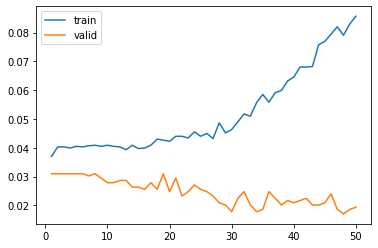

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [40]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [41]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
     |████████████████████████████████| 2.0 MB 32.6 MB/s 
     |████████████████████████████████| 253 kB 39.8 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 28.6 MB/s 
     |████████████████████████████████| 211 kB 43.9 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 42.0 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 10.9 MB 33.2 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 856 kB 42.2 MB/s 
     |████████████████████████████████| 61 kB 392 kB/s 
     |████████████████████████

In [42]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://14192.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f7845a99190>,
 'http://127.0.0.1:7860/',
 'https://14192.gradio.app')

### 6 - Generación de secuencias nuevas

In [45]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [56]:
input_text='the police aren\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=9)

"the police aren't the crisis set relationship step valentine's to imagine finds"

In [60]:
input_text='the reason is\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=20)

"the reason is't because born disneyland day step fits i aren't the one student an if shows my video more an is on"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.